In [5]:
import numpy as np
import seaborn as sn
import statsmodels.api as sm
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

# 1. Tennis Surface Check

Use a linear regression and statsmodels to find which surface type predicts the most points for Federer in the `tennis.csv` dataset.

1. Give a one-paragraph interpretation of the coefficients, and the meaning of the p-value. 

2. Answer the following: should your regression include a constant term? Why or why not? How would it change the interpretation of your coefficient and p-value?

3. Do a t-test to find that the largest coefficient is statistically significantly different from the second largest (hint: you can run a t-test only with mean values and standard deviations)

In [7]:

df = pd.read_csv('data/tennis.csv')
df = df.dropna()

print(sm.OLS(df['player1 total points won'], sm.add_constant(pd.get_dummies(df.surface, drop_first=True))).fit(cov_type='HC2').summary())


#1.1 after adding the constanct when the coef is high means that he is perform better Outdoor: Grass and Outdoor: Clay with the highest coef 
#for the P valu eis high 85% accurate 

#1.2 we should not add the constant because it will affect r-quared and the p value

#3
sp.stats.ttest_ind_from_stats(-6.1456,4.090, 1016, 15.4655, 4.344, 1016)
#It is statistically significant.

                               OLS Regression Results                               
Dep. Variable:     player1 total points won   R-squared:                       0.048
Model:                                  OLS   Adj. R-squared:                  0.044
Method:                       Least Squares   F-statistic:                     16.93
Date:                      Sat, 30 Jan 2021   Prob (F-statistic):           1.91e-13
Time:                              01:12:26   Log-Likelihood:                -4793.2
No. Observations:                      1016   AIC:                             9596.
Df Residuals:                          1011   BIC:                             9621.
Df Model:                                 4                                         
Covariance Type:                        HC2                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------

Ttest_indResult(statistic=-115.45380964705573, pvalue=0.0)

# 2. Titanic prediction contest

Use whatever tricks you can to best model whether a passenger would survive the titanic disaster (using linear regression).

1. Use non-regularized regression to build the best model you can. Show 2 alternate model speficications and explain why you chose the one you did

2. Interpret the coefficients in your model. Which attributes best relate to survival probability? How does this relate to socio-economic characteristics and "real-world" interpretation?

3. Use regularized regression to build a purely predictive model. Can you improve your accuracy? Plot the regularized model against the interpretable model predictions in a regression plot to make your case.

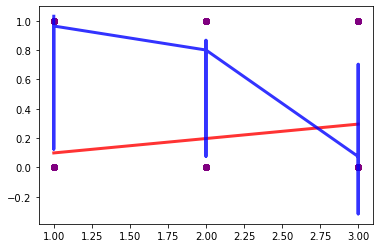

In [8]:
#For the model to work, we first need to clean this dataset.
df = sn.load_dataset('titanic')
df = df.sort_values(by='pclass')

# Convert datatypes to something more workable.
df.embarked = df.embarked.astype(str)
df['age'] = df.age.astype(float)

df['sex'] = df.sex.replace(('male', 'female'), (1, 0))
df['adult_male'] = df['adult_male'].replace((True, False), (1, 0))
df['alive'] = df['alive'].replace((True, False), (1, 0))
df['alone'] = df['alone'].replace((True, False), (1, 0))

whom = pd.get_dummies(df['who'], drop_first=True)
embark = pd.get_dummies(df['embarked'], drop_first=True)

#Drop the duplicate columns. Deck would be a useful variable but we just don't have enough data to make it useful. I will also make a copy to save for alternative models.
df_ = df.copy()
df = df.drop(['embark_town', 'class', 'deck'], axis=1)
df = df.dropna()

## 1.
# y = df.survived
# x = df[['pclass', 'fare', 'sex', 'sibsp', 'parch', 'adult_male', 'alone']]
# X = sm.add_constant(x)
# X = X.join(whom)
# X = X.join(embark)
# sm.OLS(y,X).fit(cov_type='HC2').summary()

## After a review of the p-values, I can remove some less-than-useful variables. For the sake of interpretability I dropped 'parch' due to its weak coefficient.

y = df.survived
x = df[['pclass', 'sibsp', 'adult_male', 'alone']]

X = sm.add_constant(x)
my_model = sm.OLS(y,X).fit(cov_type='HC2')
# my_model.summary()
## Alright, so the R-squared value is not fantastic but the p-values and coefficient make this a useable model, so it is the model I will go with. Lets try a few others.

## Alternative model #1.
## I really want to know the effect of deck on survival rate. Because of the small sample, we will need to drastically reduce the size of the dataset to do so.

df_ = df_.drop(['embark_town', 'class'], axis=1)
df_ = df_.dropna()

y = df_.survived
x = df_[['pclass', 'sibsp', 'adult_male', 'alone']]
X = sm.add_constant(x)
X = X.join(pd.get_dummies(df_['deck'], drop_first=True))

alt_model1 = sm.OLS(y,X).fit(cov_type='HC2')
# alt_model1.summary()

#Okay, I tried playing around with this but its just bad. Statistically insignificant (p-value) and the R-squared is next to nothing.

## Alternative model #2. 
## I was picky in the first model, so for this one we will 'kitchen-sink' style add every variable that has a significant p-value.

y = df.survived
x = df[['pclass', 'sibsp', 'parch', 'adult_male', 'alone']]
X = sm.add_constant(x)
alt_model2 = sm.OLS(y,X).fit(cov_type='HC2')
# alt_model2.summary()

#Yea, its slightly better. I don't think the increased predictability merits the extra coefficients.

## 2.
## The two strongest coefficient are 'adult_male', showing that adult_males were more likely not to survive, and 'pclass', showing that people in upper classes were more likely to survive than lower classes. The remaining 'sibsp' and 'alone' both demonstrate improved survival rates for those with family on board. 

## What we learn from this is that there is at least some truth to the idea that they saved women and children first when the Titanic sank. From a sociopolitical perspective, it is unsurprising that the upper classes with family to rely on were more likely to survive than the lower classes and those who were alone.

##3.
y = df.survived
x = df[['pclass', 'sibsp', 'adult_male', 'alone']]

X = sm.add_constant(x)
my_model = sm.OLS(y,X).fit(cov_type='HC2')
reg_model = sm.OLS(y,X).fit_regularized(method='elastic_net', alpha=0.2)

yfit = my_model.predict(X)
regfit = reg_model.predict(X)
fig, ax = plt.subplots()
ax.scatter(X['pclass'], y, color='purple', alpha=0.2)
ax.plot(X['pclass'], regfit, color='red', alpha=0.8, linewidth=3)
ax.plot(X['pclass'], yfit, color='blue', alpha=0.8, linewidth=3)

plt.show()

# House Price prediction

Using the techniques you learned, use everything you can to build the best **interpretable** (eg. non-regularized) regression model on the `house_price.csv` dataset. You also have `house_price_data_description.txt` to help -- full description of each column.

Here's a brief version of what you'll find in the data description file.

**SalePrice** - the property's sale price in dollars. **This is the target variable that you're trying to predict.**

Here are the features you can use (or engineer into new features!) for your `X` matrix:

    MSSubClass: The building class
    MSZoning: The general zoning classification
    LotFrontage: Linear feet of street connected to property
    LotArea: Lot size in square feet
    Street: Type of road access
    Alley: Type of alley access
    LotShape: General shape of property
    LandContour: Flatness of the property
    Utilities: Type of utilities available
    LotConfig: Lot configuration
    LandSlope: Slope of property
    Neighborhood: Physical locations within Ames city limits
    Condition1: Proximity to main road or railroad
    Condition2: Proximity to main road or railroad (if a second is present)
    BldgType: Type of dwelling
    HouseStyle: Style of dwelling
    OverallQual: Overall material and finish quality
    OverallCond: Overall condition rating
    YearBuilt: Original construction date
    YearRemodAdd: Remodel date
    RoofStyle: Type of roof
    RoofMatl: Roof material
    Exterior1st: Exterior covering on house
    Exterior2nd: Exterior covering on house (if more than one material)
    MasVnrType: Masonry veneer type
    MasVnrArea: Masonry veneer area in square feet
    ExterQual: Exterior material quality
    ExterCond: Present condition of the material on the exterior
    Foundation: Type of foundation
    BsmtQual: Height of the basement
    BsmtCond: General condition of the basement
    BsmtExposure: Walkout or garden level basement walls
    BsmtFinType1: Quality of basement finished area
    BsmtFinSF1: Type 1 finished square feet
    BsmtFinType2: Quality of second finished area (if present)
    BsmtFinSF2: Type 2 finished square feet
    BsmtUnfSF: Unfinished square feet of basement area
    TotalBsmtSF: Total square feet of basement area
    Heating: Type of heating
    HeatingQC: Heating quality and condition
    CentralAir: Central air conditioning
    Electrical: Electrical system
    1stFlrSF: First Floor square feet
    2ndFlrSF: Second floor square feet
    LowQualFinSF: Low quality finished square feet (all floors)
    GrLivArea: Above grade (ground) living area square feet
    BsmtFullBath: Basement full bathrooms
    BsmtHalfBath: Basement half bathrooms
    FullBath: Full bathrooms above grade
    HalfBath: Half baths above grade
    Bedroom: Number of bedrooms above basement level
    Kitchen: Number of kitchens
    KitchenQual: Kitchen quality
    TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
    Functional: Home functionality rating
    Fireplaces: Number of fireplaces
    FireplaceQu: Fireplace quality
    GarageType: Garage location
    GarageYrBlt: Year garage was built
    GarageFinish: Interior finish of the garage
    GarageCars: Size of garage in car capacity
    GarageArea: Size of garage in square feet
    GarageQual: Garage quality
    GarageCond: Garage condition
    PavedDrive: Paved driveway
    WoodDeckSF: Wood deck area in square feet
    OpenPorchSF: Open porch area in square feet
    EnclosedPorch: Enclosed porch area in square feet
    3SsnPorch: Three season porch area in square feet
    ScreenPorch: Screen porch area in square feet
    PoolArea: Pool area in square feet
    PoolQC: Pool quality
    Fence: Fence quality
    MiscFeature: Miscellaneous feature not covered in other categories
    MiscVal: $Value of miscellaneous feature
    MoSold: Month Sold
    YrSold: Year Sold
    SaleType: Type of sale
    SaleCondition: Condition of sale


In [10]:
df = pd.read_csv('data\house_price.csv')

#This dataframe is huge and intimidating. I'm going to make a function that returns the most relevant variables.

# df.dtypes.unique() #find the datatypes

def good_vars(df, corr_degree):
    final_list = []
    objects = []
    object_frame = df[['SalePrice']]

    for col in df.columns:
        if df[col].dtype == np.object:
            objects.append(col)
            object_frame = object_frame.join( pd.get_dummies(df[col], prefix=col, drop_first=True) )

    df_ = df.drop(objects, axis=1)

    for var in df_.columns:
        if df_.astype(float).corr()['SalePrice'][var] > corr_degree:
            final_list.append(var)
        else:
            pass
    for var in object_frame:
        if object_frame.astype(float).corr()['SalePrice'][var] > corr_degree:
            final_list.append(var)
        else:
            pass   

    return final_list

var_list = good_vars(df, 0.5)

In [11]:
#Alright, let's take that list and run with it.
y = df.SalePrice
x = df[var_list]
X = sm.add_constant(x)

model = sm.OLS(y,X).fit(cov_type='HC2')

# model.summary()
#Alright, this isn't perfect. Let's remove the high p-values

y = df.SalePrice
x = df[['OverallQual', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', 'GrLivArea']]
X = sm.add_constant(x)

model = sm.OLS(y,X).fit(cov_type='HC2')
model.summary()

#Not a bad model if I do say so myself. Low p-values, pretty good R-squared and strong dollar values in relation to the coeefficients.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     415.3
Date:                Sat, 30 Jan 2021   Prob (F-statistic):          5.65e-277
Time:                        01:15:13   Log-Likelihood:                -17504.
No. Observations:                1460   AIC:                         3.502e+04
Df Residuals:                    1454   BIC:                         3.505e+04
Df Model:                           5                                         
Covariance Type:                  HC2                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.343e+06    9.9e+04    -13.572      0.000   -1.54e+06   -1.15e+06
OverallQual    2.26e+04   1678.212     13.465      0.000    1.93e+04    2.59e+04
YearBuilt      371.2535     43.318      8.570      0.000     286.351     456.156
YearRemodAdd   270.6144     51.073      5.299      0.000     170.513     370.716
1stFlrSF        36.3111      7.720      4.703      0.000      21.180      51.442
GrLivArea       49.4390      6.320      7.823      0.000      37.052      61.826
==============================================================================
Omnibus:                      404.189   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35289.431
Skew:                          -0.118   Prob(JB):                         0.00
Kurtosis:                      27.084   Cond. No.                     4.03e+05
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 4.03e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""